In [1]:
import numpy as np
import ROOT as rt
from root_numpy import root2array
from glob import glob
import os, sys, re, glob
import matplotlib.pyplot as plt

from histo_utilities import create_TH2D, create_TH1D
from cebefo_style import cebefo_style

cebefo_style()

Welcome to JupyROOT 6.12/06


In [ ]:
main_dir = '/eos/user/o/ocerri/PID_timing_studies'
bkg_file_path = glob.glob(main_dir + '/_root/flat_evt_copies/pp2HardQCD*evtV2*')

Sig_file_path = {}
Sig_file_path[200] = main_dir + '/_root/flat_evt_copies/pp2RHad_PU140_M200_evtV2_50k.root'
Sig_file_path[500] = main_dir + '/_root/flat_evt_copies/pp2RHad_PU140_M500_evtV2_50k.root'
Sig_file_path[1000] = main_dir + '/_root/flat_evt_copies/pp2RHad_PU140_M1000_evtV2_40k.root'

files = {}
tree = {}
files[200] = rt.TFile(Sig_file_path[200], 'READ')
tree[200] = files[200].Get('T')

files[500] = rt.TFile(Sig_file_path[500], 'READ')
tree[500] = files[500].Get('T')

files[1000] = rt.TFile(Sig_file_path[1000], 'READ')
tree[1000] = files[1000].Get('T')

In [ ]:
# binning_SumPT = [100, 0, 4000]
N_binsx = 78
# binning_SumPT = [N_binsx, np.logspace(np.log10(30), np.log10(10e3), N_binsx+1)]
binning_SumPT = [N_binsx, np.linspace(50, 2e3, N_binsx+1)]

cut_HT = 350
cut_HT_wTOF = 150

ht_trigger = 'max_vtx_SumPT > ' + str(cut_HT)
tof_trigger = 'mh>10 && same_vtx_idx && max_vtx_SumPT > ' + str(cut_HT_wTOF)
tof_trigger_woSumPt = 'mh>10 && same_vtx_idx'

print 1+np.argmax(binning_SumPT[1] >= cut_HT)

print 1+np.argmax(binning_SumPT[1] >= cut_HT_wTOF)

In [ ]:
# del h_sumPT_bkg
h_sumPT_bkg = rt.TH1D('h_bkg', 'Hard QCD (#hat{p}_{T} > 30 GeV)', binning_SumPT[0], binning_SumPT[1])
# del h_sumPT_bkg_newTrigger
h_sumPT_bkg_newTrigger = rt.TH1D('h_bkg_new', 'Hard QCD (#hat{p}_{T} > 30 GeV), TOF trigger', binning_SumPT[0], binning_SumPT[1])
# print 'Effective xsec'

rate = 0
rate_TOF = 0

for path in bkg_file_path:
    name = os.path.basename(path[:-14])[17:-3]
    print name
    
    f = rt.TFile(path, 'READ')
    t = f.Get('T')
    
    xsec = f.Get('XSec')[0]
    NEvts = f.Get('NEvts')[0]
    eff = t.GetEntries(ht_trigger)/float(NEvts)
    print 'xsec = {:.2e} fb ({:.1e} * {:.1e})'.format(xsec*eff, xsec, eff)
    rate += xsec*eff
    
    if (eff > 0):
        h_aux = rt.TH1D('h_aux', 'h_aux', binning_SumPT[0], binning_SumPT[1])
        t.Project('h_aux', 'max_vtx_SumPT')
        h_aux.Scale(1./h_aux.GetEntries())
        h_sumPT_bkg.Add(h_aux, xsec)
    
    eff = t.GetEntries(tof_trigger)/float(NEvts)
    rate_TOF += xsec*eff
    if eff > 0:
        h_aux = rt.TH1D('h_aux2', 'h_aux2', binning_SumPT[0], binning_SumPT[1])
        t.Project('h_aux2', 'max_vtx_SumPT', tof_trigger_woSumPt)
        h_aux.Scale(1./h_aux.GetEntries())
        h_sumPT_bkg_newTrigger.Add(h_aux, xsec)
    
    f.Close()
    
rate *= 1e-15*1e-24  #from fb to cm^2
rate *= 5e34 #peak luminosity
print 'Expected rate: {:.1f} kHz'.format(1e-3 * rate)

rate_TOF *= 1e-15*1e-24  #from fb to cm^2
rate_TOF *= 5e34 #peak luminosity
print 'Expected rate (TOF): {:.1f} Hz'.format(rate_TOF)
    
# h_sumPT_bkg.Scale(rate/h_sumPT_bkg.GetEntries())
bin_N = 1+np.argmax(binning_SumPT[1] >= cut_HT)
h_sumPT_bkg.Scale(rate/h_sumPT_bkg.Integral(bin_N, binning_SumPT[0]))

# h_sumPT_bkg_newTrigger.Scale(rate_TOF/h_sumPT_bkg_newTrigger.GetEntries())
bin_N_newTrigger = 1+np.argmax(binning_SumPT[1] >= cut_HT_wTOF)
h_sumPT_bkg_newTrigger.Scale(rate_TOF/h_sumPT_bkg_newTrigger.Integral(bin_N_newTrigger, binning_SumPT[0]))

In [5]:
h_sig = {}
h_sig_new = {}


for m in Sig_file_path.keys():
    h_sig[m] = rt.TH1D('h_sig'+str(m), 'R-Hadron ('+str(m)+' GeV)', binning_SumPT[0], binning_SumPT[1])
    tree[m].Project('h_sig'+str(m), 'max_vtx_SumPT', 'exist_RHad_trk')
    h_sig[m].Scale(1./h_sig[m].GetEntries())
    
    print 'Efficiency HT ({} GeV): {:.2f}'.format(m, tree[m].GetEntries(ht_))
    
    h_sig_new[m] = rt.TH1D('h_sig_new'+str(m), 'R-Hadron ('+str(m)+' GeV), TOF trigger', binning_SumPT[0], binning_SumPT[1])
    tree[m].Project('h_sig_new'+str(m), 'max_vtx_SumPT', tof_trigger_woSumPt + ' && exist_RHad_trk')
    h_sig_new[m].Scale(1./h_sig[m].GetEntries())
    
print h_sig

{200: <ROOT.TH1D object ("h_sig200") at 0x8f53ee0>, 1000: <ROOT.TH1D object ("h_sig1000") at 0x90f3d60>, 500: <ROOT.TH1D object ("h_sig500") at 0x8fbbce0>}


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::SaveAs>: ROOT file /eos/user/o/ocerri/PID_timing_studies/_fig/paper_root/SumPT_v2.root has been created
Info in <TCanvas::Print>: png file /eos/user/o/ocerri/PID_timing_studies/_fig/paper_root/SumPT_v2.png has been created


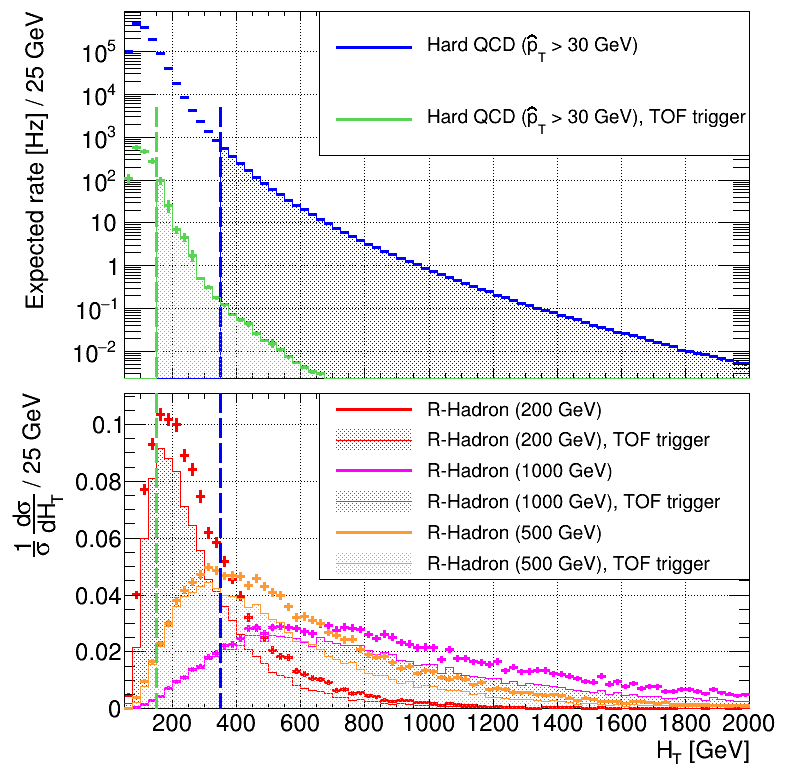

In [12]:
rt.gStyle.SetOptTitle(0)

c = rt.TCanvas('c', 'c', 800, 800)
c.Divide(1,2)

c.SetLogx()
# rt.gStyle.SetPalette(107)

line = rt.TLine()
line.SetLineWidth(3)
line.SetLineStyle(9)

pad = c.cd(1)

h_sumPT_bkg.SetLineColor(4)
h_sumPT_bkg.SetMarkerColor(4)
h_sumPT_bkg.SetStats(0)
h_sumPT_bkg.SetXTitle('H_{T} [GeV]')
h_sumPT_bkg.SetYTitle('Expected rate [Hz] / {:.0f} GeV'.format(h_sumPT_bkg.GetBinWidth(1)))
h_sumPT_bkg.GetYaxis().SetTitleSize(0.07)
h_sumPT_bkg.GetYaxis().SetTitleOffset(1.)
h_sumPT_bkg.GetYaxis().SetLabelSize(0.07)
h_sumPT_bkg.GetYaxis().SetTickSize(0.04)

h_sumPT_bkg.Draw('E')

h_sumPT_bkg_newTrigger.SetLineColor(8)
h_sumPT_bkg_newTrigger.SetMarkerColor(8)
h_sumPT_bkg_newTrigger.Draw('SAME E')
h_sumPT_bkg_newTrigger.SetStats(0)

pad.SetLogy()

leg = pad.BuildLegend(0.4, 0.6, 0.95,0.99)
line.SetLineColor(4)
line.DrawLine(cut_HT, 0, cut_HT, 5e3)
line.SetLineColor(8)
line.DrawLine(cut_HT_wTOF, 0, cut_HT_wTOF, 5e3)


h_sumPT_bkg_shadow = h_sumPT_bkg.Clone('h_sumPT_bkg_shadow')
for i in range(bin_N):
    h_sumPT_bkg_shadow.SetBinContent(i, 0.)
h_sumPT_bkg_shadow.Sumw2(0)
h_sumPT_bkg_shadow.SetLineWidth(1)
h_sumPT_bkg_shadow.SetFillColor(4)
h_sumPT_bkg_shadow.SetFillStyle(3003)
h_sumPT_bkg_shadow.Draw('Same')

h_sumPT_bkg_shadow2 = h_sumPT_bkg_newTrigger.Clone('h_sumPT_bkg_shadow2')
for i in range(bin_N_newTrigger):
    h_sumPT_bkg_shadow2.SetBinContent(i, 0.)
h_sumPT_bkg_shadow2.Sumw2(0)
h_sumPT_bkg_shadow2.SetLineWidth(1)
h_sumPT_bkg_shadow2.SetFillColor(8)
h_sumPT_bkg_shadow2.SetFillStyle(3003)
h_sumPT_bkg_shadow2.Draw('Same')

rt.gPad.SetTopMargin(0.01)
rt.gPad.SetRightMargin(0.05)
rt.gPad.SetLeftMargin(0.15)
rt.gPad.SetBottomMargin(0.0)


pad = c.cd(2)
colors = [2,6,rt.kOrange+1]
for i, m in enumerate(h_sig.keys()):
    h_sig[m].SetLineColor(colors[i])
    h_sig[m].SetMarkerColor(colors[i])
    h_sig[m].SetStats(0)
    if i == 0:
        h_sig[m].Draw('E')
        h_sig[m].SetYTitle('#frac{1}{#sigma} #frac{d#sigma}{dH_{T}} / '+ '{:.0f} GeV'.format(h_sig[m].GetBinWidth(1)))
        h_sig[m].SetXTitle('H_{T} [GeV]')
        h_sig[m].GetYaxis().SetTitleSize(0.07)
        h_sig[m].GetYaxis().SetTitleOffset(1.)
        h_sig[m].GetYaxis().SetLabelSize(0.07)
        h_sig[m].GetXaxis().SetTitleSize(0.07)
        h_sig[m].GetXaxis().SetTitleOffset(1.05)
        h_sig[m].GetXaxis().SetLabelSize(0.07)
    else:
        h_sig[m].Draw('SAME E')
    
    h_sig_new[m].Sumw2(0)
    h_sig_new[m].SetLineColor(colors[i])
    h_sig_new[m].SetLineWidth(1)
    h_sig_new[m].SetMarkerColor(colors[i])
    h_sig_new[m].SetFillColor(colors[i])
    h_sig_new[m].SetFillStyle(3003)
    h_sig_new[m].Draw('SAME')
    
leg = pad.BuildLegend(0.4, 0.5, 0.95,1)

rt.gPad.SetTopMargin(0.0)
rt.gPad.SetRightMargin(0.05)
rt.gPad.SetLeftMargin(0.15)
rt.gPad.SetBottomMargin(0.15)

line.SetLineColor(4)
line.DrawLine(cut_HT, 0, cut_HT, 0.165)
line.SetLineColor(8)
line.DrawLine(cut_HT_wTOF, 0, cut_HT_wTOF, 0.165)

c.Draw()
c.SaveAs(main_dir + '/_fig/paper_root/SumPT_v2.root')
c.SaveAs(main_dir + '/_fig/paper_root/SumPT_v2.png')